In [174]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.optimize import curve_fit
plt.style.use('./graph_preset.mplstyle')

'''
 * Author: Ryosuke AKIZAWA (ryosuke.akizawa@ipmu.jp)
 * Original Author: Takumi IZAWA (takumi.izawa@ipmu.jp)
 * Date: 2025-02-07
 * Version: 1.0
 * Description: for Kashiwa-Science-Camp
 * Internal Use Only
'''

In [175]:
class Fit_trans_refl:
    def __init__(self,i_angle,incpol,thickness):
        self.i_angle = i_angle
        self.incpol = incpol
        self.thickness = thickness

    def Fit_Func(self, n, losstan, d, freq_in, angle_i, incpol):
        c = 2.99792458e8
        num=len(d) #; the number of layer not including two ends
        const = np.sqrt((8.85418782e-12)/(4.*np.pi*1e-7)) #SI unit sqrt(dielectric const/permiability)
        # ;-----------------------------------------------------------------------------------
        # ; angle of refraction
        angle = np.zeros(num+2)          # ; angle[0]=incident angle
        angle[0] = angle_i
        for i in range(0,num+1): angle[i+1] = np.arcsin(np.sin(angle[i])*n[i]/n[i+1])
        # ;-----------------------------------------------------------------------------------
        # ; define the frequency span
        l = len(freq_in)
        output = np.zeros((3,l),'complex') # output = dcomplexarr(3,l)
        # ;-----------------------------------------------------------------------------------
        # ; define the effective thickness of each layer
        h = np.zeros(num,'complex')
        n_comparr = np.zeros(len(n),'complex')
        n_comparr[0] = complex(n[0], -0.5*n[0]*losstan[0])
        n_comparr[num+1] = complex(n[num+1], -0.5*n[num+1]*losstan[num+1])
        # ;-----------------------------------------------------------------------------------
        # ; for loop for various thickness of air gap between each layer
        for j in range(0,l):
            for i in range(0,num): 
                n_comparr[i+1] = complex(n[i+1], -0.5*n[i+1]*losstan[i+1])
                h[i] = n_comparr[i+1]*d[i]*np.cos(angle[i+1]) # ;effective thickness of 1st layer

            freq = freq_in[j]
            k = 2.*np.pi*freq/c

            # ;===========================================
            # ; Y: Y[0]=vacuum, Y[1]=1st layer..., Y[num+1]=end side
            Y = np.zeros(num+2,'complex')
            for i in range(0,num+2):
                if (incpol == 1):
                    Y[i] = const*n_comparr[i]*np.cos(angle[i])
                    cc = 1.
                if (incpol == -1):
                    Y[i] = const*n_comparr[i]/np.cos(angle[i])
                    cc = np.cos(angle[num+1])/np.cos(angle[0])

            # ;===========================================
            # ; define matrix for single layer
            m = np.identity((2),'complex')    # ; net matrix
            me = np.zeros((2,2),'complex') # ; me[0]=1st layer, ...
            for i in range(0,num):
                me[0,0] = complex(np.cos(k*h[i]), 0.)
                me[1,0] = complex(0., np.sin(k*h[i])/Y[i+1])
                me[0,1] = complex(0., np.sin(k*h[i])*Y[i+1])
                me[1,1] = complex(np.cos(k*h[i]), 0.)
                m = np.dot(m,me)

            r = (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]-m[0,1]*cc-Y[num+1]*m[1,1]) / (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]+m[0,1]*cc+Y[num+1]*m[1,1])
            t = 2.*Y[0] / (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]+m[0,1]*cc+Y[num+1]*m[1,1])

            output[0,j] = freq+0.j #; unit of [Hz]
            output[1,j] = r
            output[2,j] = t

        return output
    
    
    def Transmittance_FitIndex_1layer_incloss(self, freq, par0, par1): #[Hz]
        if par0 < 1: return 1e30
        if par1 < 0: return 1e30
    
        incpol = self.incpol
        d = np.array([self.thickness])
        angle_i = np.radians(self.i_angle)
        
        n = np.array([1.,par0,1.])
        losstan = np.array([0.,par1,0.])
        
        
        RT = self.Fit_Func( n, losstan, d, freq, angle_i, incpol)
        return np.abs(RT[2])**2
    
    
    def Reflectance_FitIndex_1layer_incloss(self, freq, par0, par1): #[Hz]
        if par0 < 1: return 1e30
        if par1 < 0: return 1e30
    
        incpol = self.incpol
        d = np.array([self.thickness])
        angle_i = np.radians(self.i_angle)

        n = np.array([1.,par0,1.])
        losstan = np.array([0.,par1,0.])
        
        RT = self.Fit_Func( n, losstan, d, freq, angle_i, incpol)
        return np.abs(RT[1])**2
    

def multiple_row_plot(rows, cols, row_ratios=None, col_ratios=None, figsize=(8,12)):
    """
    Create a grid of subplots with adjustable row and column ratios and external figsize.

    Args:
        rows (int): Number of rows.
        cols (int): Number of columns.
        row_ratios (list, optional): Relative heights of rows.
        col_ratios (list, optional): Relative widths of columns.
        figsize (tuple, optional): Figure size (width, height). Default is (8, 12).

    Returns:
        list: List of subplot axes.
    """
    fig = plt.figure(figsize=figsize,dpi=100)
    gs = gridspec.GridSpec(
        rows,
        cols,
        height_ratios=row_ratios,
        width_ratios=col_ratios,
        hspace=0.0,
        wspace=0.0,
    )
    ax_grid = [plt.subplot(gs[i]) for i in range(rows)]
    for ax in ax_grid[:-1]:
        plt.setp(ax.get_xticklabels(), visible=False)
    return ax_grid

In [176]:
# initializtion
# select data
data_air_before = dict(np.load('data/mockdata_air_before.npz'))
data_sample =  dict(np.load('./data/mockdata_sample_p.npz'))
data_air_after = dict(np.load('./data/mockdata_air_after.npz'))

# check the data format
for key in data_sample.keys():
    print(f"  {key:<8}: (rows, columns) = {data_sample[key].shape}")

# convert the frequency from GHz to Hz
data_sample['freq'] = data_sample['freq']*1e9

# convert from dB to Transmittance
data_air_before['data'] = 10**(data_air_before['data']/10)
data_sample['data'] = 10**(data_sample['data']/10)
data_air_after['data'] = 10**(data_air_after['data']/10)
sigma_weight = np.full(len(data_sample['freq']), 0.00984636)

# set initial parameters
incpol=-1 # (-1: p-polarization, 1: s-polarization)
inc_angle = 0 # incident angle [deg]
thickness = 2.1e-3 # thickness [m]
n_init = 3.047 # Refractive index
los_init = 0 # Loss tangent
# =================================

# param init
param_init = [n_init, los_init]

# Call a class functions
lib_functions = Fit_trans_refl(inc_angle,incpol,thickness)

  freq    : (rows, columns) = (1000,)
  data    : (rows, columns) = (1000,)
  trans   : (rows, columns) = (1000,)
  phase   : (rows, columns) = (1000,)
  real    : (rows, columns) = (1000,)
  imag    : (rows, columns) = (1000,)


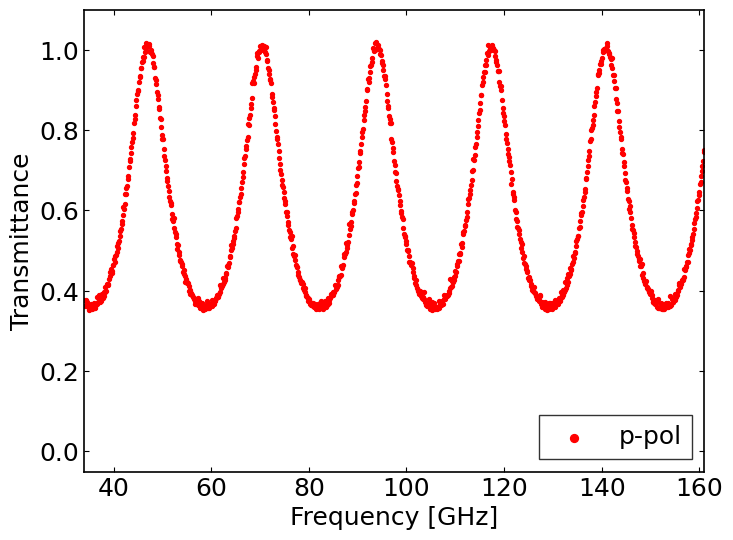

In [177]:
fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(data_sample['freq']*1e-9,data_sample['trans'],label='p-pol',color='r',s=8)
ax.set_ylim(-0.05,1.1)
ax.set_xlim(34,161)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Transmittance')
ax.legend(loc='lower right')

In [178]:
popt_p, pcov_p = curve_fit(lib_functions.Transmittance_FitIndex_1layer_incloss,
                       data_sample['freq'],
                       data_sample['trans'],
                       p0=param_init,
                       sigma = sigma_weight,
                       absolute_sigma=True,
                       maxfev=10000,
                       bounds=([2.5, 0], [4, 0.1]))

perr = np.sqrt(np.diag(pcov_p))


print("=== Fit Results ===")
print("{:<5} {:>12} {:>12}".format("Index", "Value", "Error"))
for i, (p, err) in enumerate(zip(popt_p, perr)):
    print(f"{i:<5d} {p:12.4f} {err:12.4f}")

# chi2
fitted_curve = lib_functions.Transmittance_FitIndex_1layer_incloss(data_sample['freq'], *popt_p)
residual = data_sample['trans'] - fitted_curve
residual_rms = np.sqrt(np.mean(residual**2))

chi2 = np.sum((residual/sigma_weight)**2)
dof = len(data_sample['freq'])-len(popt_p)

print(f"Reduced chi2: {chi2/dof:.8f}")
print(f"RMS of residual: {residual_rms:.8f}")

=== Fit Results ===
Index        Value        Error
0           3.0406       0.0001
1           0.0000       0.0000
Reduced chi2: 1.00200389
RMS of residual: 0.00984636


=== Fit Results ===
Best fit n1: 3.0406 ± 0.0001
Best fit losstan: 0.00000 ± 0.00003


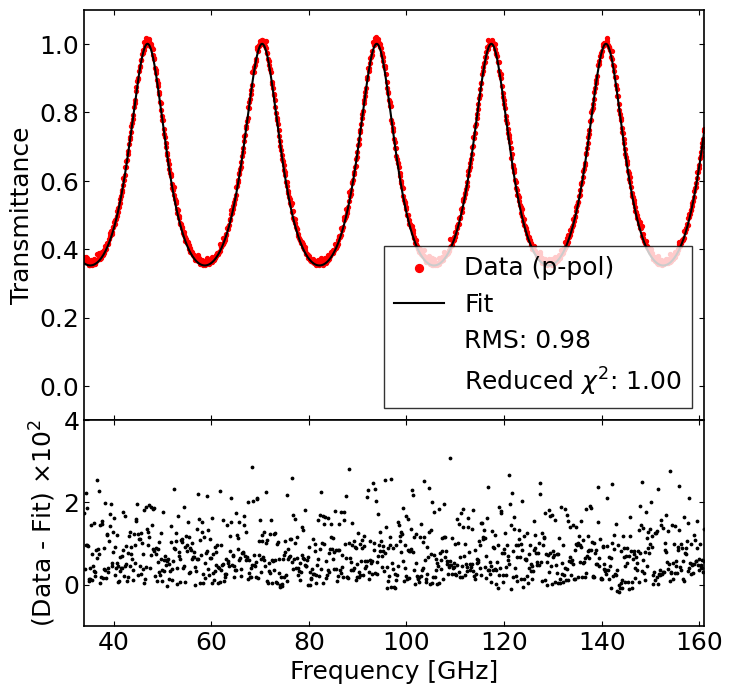

In [184]:
# Result plot
ax = multiple_row_plot(2, 1, row_ratios=(2,1),figsize=(8, 8))
ax[0].scatter(data_sample['freq']*1e-9,data_sample['trans'],label='Data (p-pol)',color='r',s=8)
ax[0].plot(data_sample['freq']*1e-9,fitted_curve,label='Fit',color='k')
ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(34,161)
ax[0].set_xlabel('Frequency [GHz]')
ax[0].set_ylabel('Transmittance')
ax[0].scatter([],[],color='none',label=f"RMS: {residual_rms*10**2:.2f}")
ax[0].scatter([],[],color='none',label=r"Reduced $\chi^2$: {:.2f}".format(chi2/dof))
ax[0].legend(loc='lower right')

ax[1].scatter(data_sample['freq']*1e-9,residual*10**2,color='k',s=3)
ax[1].set_ylim(-1,4)
ax[1].set_xlim(34,161)
ax[1].set_xlabel('Frequency [GHz]')
ax[1].set_ylabel(r'(Data - Fit) $\times 10^2$')

print("=== Fit Results ===")
print(f"Best fit n1: {popt_p[0]:.4f} ± {perr[0]:.4f}")
print(f"Best fit losstan: {popt_p[1]:.5f} ± {perr[1]:.5f}")

plt.show()